In [1]:
from latentmi import lmi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc 
from tqdm.notebook import tqdm
import os
from sklearn.neighbors import NearestNeighbors

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# base directory for embeddings
embeddings_dir = '../embeddings/LARRY/'
results = []

# loop through quality and replicate subdirectories
for quality_dir in os.listdir(embeddings_dir):
    quality_path = os.path.join(embeddings_dir, quality_dir)
    if not os.path.isdir(quality_path):
        continue

    # find held-out cells
    held_out_path = os.path.join(quality_path, 'held_out_cells.h5ad')
    held_out = sc.read_h5ad(held_out_path)

    # organize clonewise data
    early_clones = held_out[held_out.obs['time'].isin([2,4])]
    late_clones = held_out[held_out.obs['time'] == 6]
    common_clones = set([x for x in early_clones.obs['clone'].values 
                        if x in late_clones.obs['clone'].values])
    print("Number of common clones: %d" %(len(common_clones)))

    cxf = held_out.to_df().reset_index()

    for name in held_out.obs.keys():
        cxf[name] = held_out.obs[name].values
    rnas = cxf.keys()[:-7]
    early = cxf[(cxf['time'].isin([2,4])) 
                    & (cxf['clone'].isin(common_clones))].groupby('clone').sample(n=1)
    late = cxf[(cxf['time'] == 6) & (cxf['clone'].isin(
        common_clones))].groupby('clone').sample(n=1)

    UMI_per_cell = held_out.raw.X.sum()/len(held_out)

    # loop through embedding files
    for file in tqdm(os.listdir(quality_path), desc=f"Processing {quality_dir}"):
        if not file.endswith('.npy'):
            continue

        # extract method and fraction from filename
        method, frac = file.split('_')
        frac = frac[4:-4]

        # load embeddings
        embedding_path = os.path.join(quality_path, file)
        embeddings = np.load(embedding_path)

        # estimate MI
        pmis, _, _ = lmi.estimate(embeddings[early.index], embeddings[late.index], 
                                  quiet=True, batch_size=2048, N_dims=16)
        protein_mi = np.nanmean(pmis)

        # save result
        results.append({
            'Quality': quality_dir.split('_')[0],
            'UMI per cell' : UMI_per_cell,
            'Replicate': quality_dir.split('_')[1],
            'Fraction': float(frac),

            # watch out ! this needs to be tweaked if we change hold out size
            'Cell number' : int(float(frac)*3*len(held_out)),
            'Method': method,
            'Clonal MI': protein_mi,
        })

Number of common clones: 2205


Processing Q0.001_rep0:   0%|          | 0/59 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Number of common clones: 2205


Processing Q0.002_rep0:   0%|          | 0/59 [00:00<?, ?it/s]

epoch 241 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Number of common clones: 2205


Processing Q0.005_rep0:   0%|          | 0/59 [00:00<?, ?it/s]

epoch 208 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Number of common clones: 2205


Processing Q0.010_rep0:   0%|          | 0/59 [00:00<?, ?it/s]

epoch 216 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Number of common clones: 2205


Processing Q0.022_rep0:   0%|          | 0/59 [00:00<?, ?it/s]

epoch 176 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Number of common clones: 2205


Processing Q0.046_rep0:   0%|          | 0/59 [00:00<?, ?it/s]

epoch 156 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Number of common clones: 2205


Processing Q0.100_rep0:   0%|          | 0/59 [00:00<?, ?it/s]

epoch 138 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Number of common clones: 2205


Processing Q0.215_rep0:   0%|          | 0/59 [00:00<?, ?it/s]

epoch 163 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Number of common clones: 2205


Processing Q0.464_rep0:   0%|          | 0/59 [00:00<?, ?it/s]

epoch 172 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻Number of common clones: 2205


Processing Q1.000_rep0:   0%|          | 0/59 [00:00<?, ?it/s]

epoch 148 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

In [3]:
df = pd.DataFrame(results)
df

,Quality,UMI per cell,Replicate,Fraction,Cell number,Method,Clonal MI
0,Q0.001,2.583231,rep0,0.001,196,VAE,-0.007441
1,Q0.001,2.583231,rep0,0.001,196,PCA,0.016149
2,Q0.001,2.583231,rep0,0.001,196,RandomProjection,0.020749
3,Q0.001,2.583231,rep0,0.001,196,nanoTxformer,-0.009617
4,Q0.001,2.583231,rep0,0.002,392,VAE,0.001442
...,...,...,...,...,...,...,...
335,Q1.000,2586.993980,rep0,0.464,91098,RandomProjection,0.624762
336,Q1.000,2586.993980,rep0,1.000,196332,VAE,1.869713
337,Q1.000,2586.993980,rep0,1.000,196332,PCA,1.568444
338,Q1.000,2586.993980,rep0,1.000,196332,RandomProjection,0.648020


In [4]:
df.to_csv('../results/LARRY_scaling.csv')

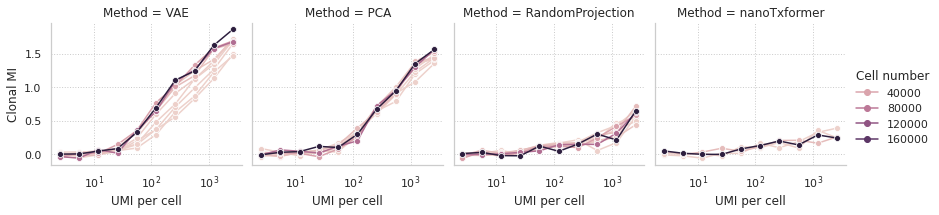

In [10]:
sns.relplot(df, x='UMI per cell', y='Clonal MI',
            col='Method', hue='Cell number', kind='line', marker='o', height=3)
plt.xscale('log')

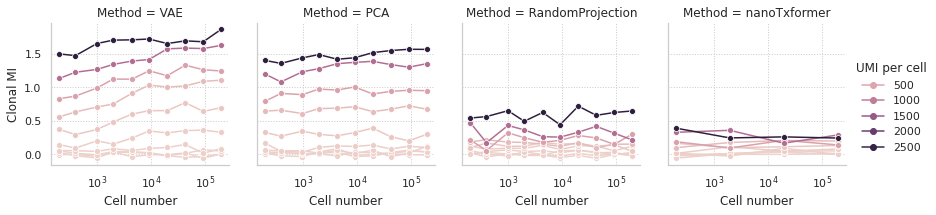

In [7]:
sns.relplot(df, hue='UMI per cell', y='Clonal MI',
            col='Method', x='Cell number', kind='line', marker='o', height=3)
plt.xscale('log')

/tmp/ipykernel_2926383/3885022227.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


0.005832707967182952
0.002173565329856973
0.005630054172965402
0.0018102075641132707


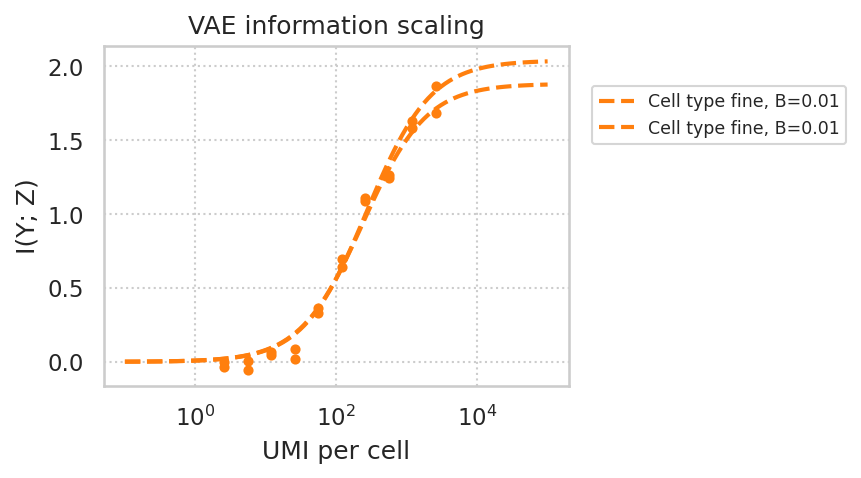

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit
from matplotlib.cm import get_cmap

n = 1
def info_scaling(x, A, B):
    # return (n/2) * np.log2((1 + A*x*(1+B))/(1+A*B*x))
    return np.log2((x*(A+B)+ 1)/(1+A*x))

# group and filter data
filtered_df = df[df['Cell number'] > 5 * 10**4]
filtered_df = filtered_df[filtered_df['Method'].isin(['VAE'])]
grouped = filtered_df.groupby(['Method', 'Cell number'])

# setup plot
rcParams['figure.dpi'] = 150
x_fit = np.logspace(-1, 5, 100)
cmap = get_cmap('tab10')

plt.figure(figsize=(4, 3))

for (representation, n_cells), group in grouped:
    x_data = group['UMI per cell']
    y_data = group['Clonal MI']
    plt.scatter(x_data, y_data, color=cmap(1), s=15)
    try:
        popt, pcov = curve_fit(info_scaling, x_data, y_data, 
                               p0=[1.0, 1.0], bounds = ([0, 0], [np.inf, np.inf]))
        A_fit, B_fit = popt
        print(B_fit)
        print(A_fit)
        plt.plot(x_fit, info_scaling(x_fit, A_fit, B_fit), linestyle='dashed',
                    label=f"Cell type fine, B={B_fit:.2f}", 
                    color=cmap(1), lw=2)
    except RuntimeError:
        print(f"Fit failed for Rep {representation}, N cells {n_cells}")

# finalize plot
plt.xscale('log')
plt.xlabel("UMI per cell")
plt.ylabel("I(Y; Z)")
plt.title("VAE information scaling")
plt.legend(loc=(1.05, .71), fontsize="small", ncol=1)
plt.show()


In [12]:
# def inverse_scaling(y, A, B):
#     return (A*(B + 1)*(2**(2*y)))/(B*(B + 1 - 2**(2*y)))

# max_I = 0.5*np.log2(1+B_fit)
max_I = (n/2)* np.log2((1 + B_fit)**n/B_fit**n)
print(max_I)

# print(inverse_scaling(0.95*max_I, A_fit, B_fit))

print(x_data.iloc[-1])
print(y_data.iloc[-1])
print(y_data.iloc[-1]/max_I)

2.1662850135700107
2586.9939795856
1.869713323909197
0.8630966434227104


/tmp/ipykernel_2876481/4228304050.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')
/home/gokul/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/gokul/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.07863437315878063
0.039231671581342484
0.039407122161060806
0.010350017532896287
0.010513934845721344
0.07403932142263388
0.039231671581342484
0.039407122161060806
0.010350017532896287
0.010513934845721344


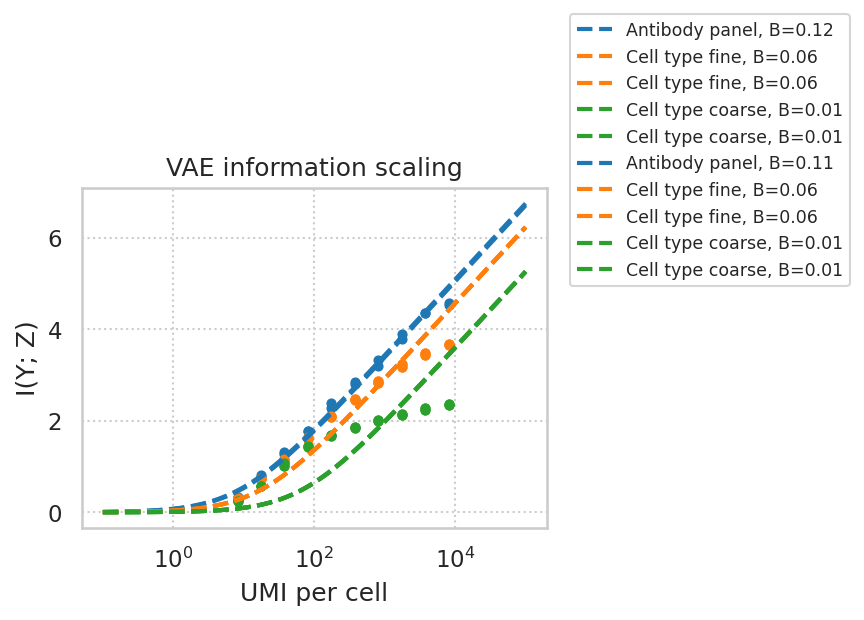

In [ ]:
def info_scaling(x, A, B):
    return 0.5 * np.log2(1+B*x)

# group and filter data
filtered_df = df[df['Cell number'] > 5 * 10**4]
filtered_df = filtered_df[filtered_df['Method'].isin(['VAE'])]
grouped = filtered_df.groupby(['Method', 'Cell number'])

# setup plot
rcParams['figure.dpi'] = 150
x_fit = np.logspace(-1, 5, 100)
cmap = get_cmap('tab10')

plt.figure(figsize=(4, 3))
for (representation, n_cells), group in grouped:
    x_data = group['UMI per cell']
    y_data = group['Protein MI']
    plt.scatter(x_data, y_data, color=cmap(0), s=15)
    try:
        popt, pcov = curve_fit(info_scaling, x_data, y_data, p0=[1.0, 1.0])
        A_fit, B_fit = popt
        print(0.5*np.log2(B_fit + 1))
        plt.plot(x_fit, info_scaling(x_fit, A_fit, B_fit), linestyle='dashed',
                    label=f"Antibody panel, B={B_fit:.2f}", 
                    color=cmap(0), lw=2)
    except RuntimeError:
        print(f"Fit failed for Rep {representation}, N cells {n_cells}")

    for (representation, n_cells), group in grouped:
        x_data = group['UMI per cell']
        y_data = group['Cell type fine MI']
        plt.scatter(x_data, y_data, color=cmap(1), s=15)
        try:
            popt, pcov = curve_fit(info_scaling, x_data, y_data, p0=[1.0, 1.0])
            A_fit, B_fit = popt
            print(0.5*np.log2(B_fit + 1))
            plt.plot(x_fit, info_scaling(x_fit, A_fit, B_fit), linestyle='dashed',
                        label=f"Cell type fine, B={B_fit:.2f}", 
                        color=cmap(1), lw=2)
        except RuntimeError:
            print(f"Fit failed for Rep {representation}, N cells {n_cells}")
    
    for (representation, n_cells), group in grouped:
        x_data = group['UMI per cell']
        y_data = group['Cell type coarse MI']
        plt.scatter(x_data, y_data, color=cmap(2), s=15)
        try:
            popt, pcov = curve_fit(info_scaling, x_data, y_data, p0=[1.0, 1.0])
            A_fit, B_fit = popt
            print(0.5*np.log2(B_fit + 1))
            plt.plot(x_fit, info_scaling(x_fit, A_fit, B_fit), linestyle='dashed',
                        label=f"Cell type coarse, B={B_fit:.2f}", 
                        color=cmap(2), lw=2)
        except RuntimeError:
            print(f"Fit failed for Rep {representation}, N cells {n_cells}")

# finalize plot
plt.xscale('log')
plt.xlabel("UMI per cell")
plt.ylabel("I(Y; Z)")
plt.title("VAE information scaling")
plt.legend(loc=(1.05, .71), fontsize="small", ncol=1)
plt.show()